# Install dependencies and initialize variables

In [ ]:
!pip install data
!pip install hickle

  Created wheel for data: filename=data-0.4-cp36-none-any.whl size=7247 sha256=46a63cd9ea136407367f85124052c49692326eed8fba98a458516ffa6f37ae30
  Stored in directory: /root/.cache/pip/wheels/f6/09/e5/5afbc45fb0de471541092c7cd8b48d3483be68b1890955e6b9
Successfully built data
     |████████████████████████████████| 51kB 6.4MB/s 


In [ ]:
import os
import cv2
import hickle
from glob import glob
from tqdm import tqdm
import data
import random
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
card_suits=['s','h','d','c']
card_values=['A','K','Q','J','10','9','8','7','6','5','4','3','2']

# Physical dimensions of playing card. May vary
cardW=64
cardH=89
cornerXmin=1.5
cornerXmax=9.5
cornerYmin=2.5
cornerYmax=23

zoom=4
cardW*=zoom
cardH*=zoom
cornerXmin=int(cornerXmin*zoom)
cornerXmax=int(cornerXmax*zoom)
cornerYmin=int(cornerYmin*zoom)
cornerYmax=int(cornerYmax*zoom)

# imgW,imgH: dimensions of the generated dataset images
imgW=720
imgH=720

refCard=np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
refCardRot=np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)
refCornerHL=np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
refCornerLR=np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)
refCorners=np.array([refCornerHL,refCornerLR])




def give_me_filename(dirname, suffixes, prefix=""):
    """
        Function that returns a filename or a list of filenames in directory 'dirname'
        that does not exist yet. If 'suffixes' is a list, one filename per suffix in 'suffixes':
        filename = dirname + "/" + prefix + random number + "." + suffix
        Same random number for all the file name
        Ex:
        > give_me_filename("dir","jpg", prefix="prefix")
        'dir/prefix408290659.jpg'
        > give_me_filename("dir",["jpg","xml"])
        ['dir/877739594.jpg', 'dir/877739594.xml']
    """
    if not isinstance(suffixes, list):
        suffixes = [suffixes]

    suffixes = [p if p[0] == '.' else '.' + p for p in suffixes]

    while True:
        bname = "%09d" % random.randint(0, 999999999)
        fnames = []
        for suffix in suffixes:
            fname = os.path.join(dirname, prefix + bname + suffix)
            if not os.path.isfile(fname):
                fnames.append(fname)

        if len(fnames) == len(suffixes): break

    if len(fnames) == 1:
        return fnames[0]
    else:
        return fnames


# Download Describable Textures Dataset

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

--2020-07-01 15:22:29--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/x-gzip]
Saving to: ‘dtd-r1.0.1.tar.gz’

dtd-r1.0.1.tar.gz   100%[===================>] 596.27M  10.1MB/s    in 61s     

2020-07-01 15:23:32 (9.74 MB/s) - ‘dtd-r1.0.1.tar.gz’ saved [625239812/625239812]



In [ ]:
!tar xf dtd-r1.0.1.tar.gz

Nb of images loaded : 5640
Saved in : backgrounds.hkl
Nb of images loaded : 5640


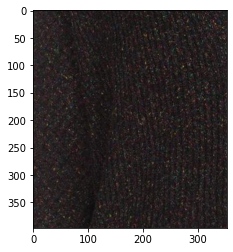

In [ ]:
dtd_dir="dtd/images/"
backgrounds_hkl_fn = "backgrounds.hkl"
bg_images=[]
for subdir in glob(dtd_dir+"/*"):
    for f in glob(subdir+"/*.jpg"):
        bg_images.append(mpimg.imread(f))
print("Nb of images loaded :",len(bg_images))
print("Saved in :",backgrounds_hkl_fn)
hickle.dump(bg_images,open(backgrounds_hkl_fn, mode='w'))


class Backgrounds():
    def __init__(self, backgrounds_hkl_fn=backgrounds_hkl_fn):
        self._images = hickle.load(backgrounds_hkl_fn)
        self._nb_images = len(self._images)
        print("Nb of images loaded :", self._nb_images)

    def get_random(self, display=False):
        bg = self._images[random.randint(0, self._nb_images - 1)]
        if display: plt.imshow(bg)
        return bg


backgrounds = Backgrounds()
_=backgrounds.get_random(display=True)

# Find convex hull in image

In [ ]:
def findHull(img, corner = refCornerHL, debug = False):
    """
            Find in the zone 'corner' of image 'img' and return, the convex hull delimiting
            the value and suit symbols
            'corner' (shape (4,2)) is an array of 4 points delimiting a rectangular zone,
            takes one of the 2 possible values : refCornerHL or refCornerLR
            debug=
        """

    kernel = np.ones((3,3), np.uint8)
    corner = corner.astype(np.int)

    x1 = int(corner[0][0])
    y1 = int(corner[0][1])
    x2 = int(corner[2][0])
    y2 = int(corner[2][1])
    w = x2 - x1
    h = y2 - y1
    zone = img[y1:y2, x1:x2].copy()

    strange_cnt = np.zeros_like(zone)
    gray = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    thld = cv2.Canny(gray, 30, 200)
    thld = cv2.dilate(thld, kernel, iterations=1)
    if debug != "no":
        cv2.imshow("thld", thld)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    # Find contours
    contours, _ = cv2.findContours(thld.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 30 # Reject contours with a small area. TWEAK 'zoom' dependent
    min_solidity = 0.3 # reject contours with a low solidity TWEAK

    concat_contour = None
    ok = True
    for c in contours:
        area = cv2.contourArea(c)

        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area
        # Determine the center of gravity (cx,cy) of the contour
        M = cv2.moments(c)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        #  abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 : TWEAK, the idea here is to keep only the contours which are closed to the center of the zone
        if area >= min_area and abs(w / 2 - cx) < w * 0.3 and abs(h / 2 - cy) < h * 0.4 and solidity > min_solidity:
            if debug != "no":
                cv2.drawContours(zone, [c], 0, (255, 0, 0), -1)
            if concat_contour is None:
                concat_contour = c
            else:
                concat_contour = np.concatenate((concat_contour, c))
        if debug != "no" and solidity <= min_solidity:
            print("Solidity", solidity)
            cv2.drawContours(strange_cnt, [c], 0, 255, 2)
            cv2.imshow("Strange contours", strange_cnt)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

    if concat_contour is not None:
        # At this point, we suppose that 'concat_contour' contains only the contours corresponding the value and suit symbols
        # We can now determine the hull
        hull = cv2.convexHull(concat_contour)
        hull_area = cv2.contourArea(hull)
        # If the area of the hull is to small or too big, there may be a problem
        min_hull_area = 940  # TWEAK, deck and 'zoom' dependant
        max_hull_area = 2120  # TWEAK, deck and 'zoom' dependant
        if hull_area < min_hull_area or hull_area > max_hull_area:
            ok = False
            if debug != "no":
                print("Hull area=", hull_area, "too large or too small")
        # So far, the coordinates of the hull are relative to 'zone'
        # We need the coordinates relative to the image -> 'hull_in_img'
        hull_in_img = hull + corner[0]

    else:
        ok = False

    if debug != "no":
        if concat_contour is not None:
            cv2.drawContours(zone, [hull], 0, (0, 255, 0), 1)
            cv2.drawContours(img, [hull_in_img], 0, (0, 255, 0), 1)
        cv2.imshow("Zone", zone)
        cv2.imshow("Image", img)
        if ok and debug != "pause_always":
            key = cv2.waitKey(1)
        else:
            key = cv2.waitKey(0)
        if key == 27:
            return None
    if ok == False:
        return None

    return hull_in_img


def display_img(img, polygons=None, channels="bgr", size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if polygons is None:
        polygons = []
    if not isinstance(polygons,list):
        polygons=[polygons]
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)


    for polygon in polygons:
        # An polygon has either shape (n,2),
        # either (n,1,2) if it is a cv2 contour (like convex hull).
        # In the latter case, reshape in (n,2)
        if len(polygon.shape)==3:
            polygon=polygon.reshape(-1,2)
        patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(patch)



def testDimensions():

    """
        These 5 lines take 5 random cards and draw a box around the corners.
        Used to test the dimensions CardW, CardH, CornerXMin, CornerXMax, CornerYMin, and CornerYMax
    """
    imgs_dir = "cards_cropped"
    imgs_fns = glob(imgs_dir + "/*.JPG")
    for _ in range(0, 10):
        img_fn = random.choice(imgs_fns)
        display_img(cv2.imread(img_fn, cv2.IMREAD_UNCHANGED), polygons=[data.refCornerHL, data.refCornerLR])


def testHull():
    debug="no"
    imgs_dir="cards_cropped"
    imgs_fns=glob(imgs_dir+"/*.JPG")
    img_fn=random.choice(imgs_fns)
    print(img_fn)
    img=cv2.imread(img_fn,cv2.IMREAD_UNCHANGED)

    hullHL=findHull(img,data.refCornerHL,debug=debug)
    hullLR=findHull(img,data.refCornerLR,debug=debug)
    display_img(img,[data.refCornerHL,data.refCornerLR,hullHL,hullLR])


In [ ]:
%cd /content

/content


In [ ]:
class Cards():
    """
        Loads the 'cards.hkl' file into an instance of Card class
    """
    def __init__(self):
        self._cards = hickle.load("cards.hkl")
        # self.cards is a dictionary
        # Keys: card names, Kc, 10s, 7d
        # Values: lists of (img, hullHL, hullLR)

        self._num_cards_by_value = {k : len(self._cards[k]) for k in self._cards}
        print("No. of cards loaded per name: ", self._num_cards_by_value)

    def get_random(self, card_name = None, display=False):
        if card_name is None:
            card_name = random.choice(list(self._cards.keys()))
        card, hull1, hull2 = self._cards[card_name][random.randint(0, self._num_cards_by_value[card_name]-1)]
        if display:
            display_img(card, [hull1, hull2], "rgb")
        return card,card_name,hull1,hull2


def change_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    if value > 0:
        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value
        final = cv2.merge((h, s, v))
    else:
        value = abs(value)
        lim = value
        v[v < lim] = 0
        v[v >= lim] -= value
        final = cv2.merge((h, s, v))
    img = cv2.cvtColor(final, cv2.COLOR_HSV2BGR)
    return img

def edit_cards():
    images = list()

    for image_string in os.listdir("cropped_cards"):
        image = cv2.imread(f"cropped_cards/{image_string}")
        for i in range(0, 100, 4):
            image_string = image_string.replace(".JPG", "")
            path = os.path.join("edited_cards", image_string)
            print(path)
            if not os.path.exists(path):
                os.makedirs(path)
            bright_image = change_brightness(image, i)
            dark_image = change_brightness(image, i * -1)
            bright_path = os.path.join(path, f"{image_string}_{i}_b.JPG")
            dark_path = os.path.join(path, f"{image_string}_{i}_d.JPG")
            cv2.imwrite(bright_path, bright_image)
            cv2.imwrite(dark_path, dark_image)


def saveToHickle():
    imgs_dir = "/content/drive/My Drive/cards_filter"
    cards = {}
    for suit in card_suits:
        for value in card_values:
            card_name = value+suit
            card_dir = os.path.join(imgs_dir, card_name)
            if not os.path.isdir(card_dir):
                print(f"{card_dir} does not exist")
                continue
            cards[card_name] = []
            for f in glob(card_dir + "/*.JPG"):
                img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
                hullHL = findHull(img, refCornerHL, debug="no")
                if hullHL is None:
                    print(f"File {f} not used.")
                    continue
                hullLR = findHull(img, refCornerLR, debug="no")
                if hullLR is None:
                    print(f"File {f} not used.")
                    continue
                # Store the image in RBG format
                # OpenCV is no longer needed
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
                cards[card_name].append((img, hullHL, hullLR))
            print(f"No. images for {card_name} : {len(cards[card_name])}")
    print("Saved in: ", "cards.hkl")
    hickle.dump(cards, "cards.hkl", mode='w')


xml_body_1="""<annotation>
        <folder>FOLDER</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

def create_voc_xml(xml_file, img_file,listbba,display=False):

    with open(xml_file,"w") as f:
        f.write(xml_body_1.format(**{'FILENAME':os.path.basename(img_file), 'PATH':img_file,'WIDTH':imgW,'HEIGHT':imgH}))
        for bba in listbba:
            f.write(xml_object.format(**{'CLASS':bba.classname,'XMIN':bba.x1,'YMIN':bba.y1,'XMAX':bba.x2,'YMAX':bba.y2}))
        f.write(xml_body_2)
        if display: print("New xml",xml_file)
saveToHickle()

No. images for As : 50
No. images for Ks : 50
No. images for Qs : 50
No. images for Js : 50
No. images for 10s : 50
No. images for 9s : 50
No. images for 8s : 50
No. images for 7s : 50
No. images for 6s : 50
No. images for 5s : 50
No. images for 4s : 50
No. images for 3s : 50
No. images for 2s : 50
No. images for Ah : 50
No. images for Kh : 50
No. images for Qh : 50
No. images for Jh : 50
No. images for 10h : 50
No. images for 9h : 50
No. images for 8h : 50
No. images for 7h : 50
No. images for 6h : 50
No. images for 5h : 50
No. images for 4h : 50
No. images for 3h : 50
No. images for 2h : 50
No. images for Ad : 50
No. images for Kd : 50
No. images for Qd : 50
No. images for Jd : 50
No. images for 10d : 50
No. images for 9d : 50
No. images for 8d : 50
No. images for 7d : 50
No. images for 6d : 50
No. images for 5d : 50
No. images for 4d : 50
No. images for 3d : 50
No. images for 2d : 50
No. images for Ac : 50
No. images for Kc : 50
No. images for Qc : 50
No. images for Jc : 50
No. imag

**TODO: ** Download .hkl file from website

No. of cards loaded per name:  {'As': 50, 'Ks': 50, 'Qs': 50, 'Js': 50, '10s': 50, '9s': 50, '8s': 50, '7s': 50, '6s': 50, '5s': 50, '4s': 50, '3s': 50, '2s': 50, 'Ah': 50, 'Kh': 50, 'Qh': 50, 'Jh': 50, '10h': 50, '9h': 50, '8h': 50, '7h': 50, '6h': 50, '5h': 50, '4h': 50, '3h': 50, '2h': 50, 'Ad': 50, 'Kd': 50, 'Qd': 50, 'Jd': 50, '10d': 50, '9d': 50, '8d': 50, '7d': 50, '6d': 50, '5d': 50, '4d': 50, '3d': 50, '2d': 50, 'Ac': 50, 'Kc': 50, 'Qc': 50, 'Jc': 50, '10c': 50, '9c': 50, '8c': 50, '7c': 50, '6c': 50, '5c': 50, '4c': 50, '3c': 50, '2c': 50}


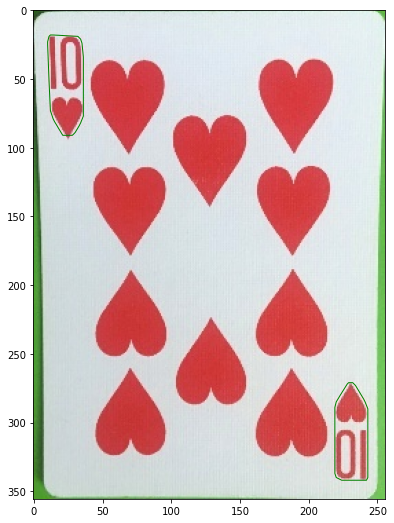

In [ ]:
cards = Cards()

_ = cards.get_random(display=True)

# Generate random image

In [ ]:
decalX=int((imgW-cardW)/2)
decalY=int((imgH-cardH)/2)

# Scenario with 3 cards : decal values are different
decalX3=int(imgW/2)
decalY3=int(imgH/2-cardH)

def kps_to_polygon(kps):
    """
        Convert imgaug keypoints to shapely polygon
    """
    pts=[(kp.x,kp.y) for kp in kps]
    return Polygon(pts)

def hull_to_kps(hull, decalX=decalX, decalY=decalY):
    """
        Convert hull to imgaug keypoints
    """
    # hull is a cv2.Contour, shape : Nx1x2
    kps=[ia.Keypoint(x=p[0]+decalX,y=p[1]+decalY) for p in hull.reshape(-1,2)]
    kps=ia.KeypointsOnImage(kps, shape=(imgH,imgW,3))
    return kps


def kps_to_BB(kps):
    """
        Determine imgaug bounding box from imgaug keypoints
    """
    extend=3 # To make the bounding box a little bit bigger
    kpsx=[kp.x for kp in kps.keypoints]
    minx=max(0,int(min(kpsx)-extend))
    maxx=min(imgW,int(max(kpsx)+extend))
    kpsy=[kp.y for kp in kps.keypoints]
    miny=max(0,int(min(kpsy)-extend))
    maxy=min(imgH,int(max(kpsy)+extend))
    if minx==maxx or miny==maxy:
        return None
    else:
        return ia.BoundingBox(x1=minx,y1=miny,x2=maxx,y2=maxy)


# imgaug keypoints of the bounding box of a whole card
cardKP = ia.KeypointsOnImage([
    ia.Keypoint(x=decalX,y=decalY),
    ia.Keypoint(x=decalX+cardW,y=decalY),
    ia.Keypoint(x=decalX+cardW,y=decalY+cardH),
    ia.Keypoint(x=decalX,y=decalY+cardH)
    ], shape=(imgH,imgW,3))

# imgaug transformation for one card in scenario with 2 cards
transform_1card = iaa.Sequential([
    iaa.Affine(scale=[0.65,1]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.25,0.25),"y":(-0.25,0.25)}),
])

# For the 3 cards scenario, we use 3 imgaug transforms, the first 2 are for individual cards,
# and the third one for the group of 3 cards
trans_rot1 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (10, 20)}),
    iaa.Affine(rotate=(22,30))
])
trans_rot2 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (0, 5)}),
    iaa.Affine(rotate=(10,15))
])
transform_3cards = iaa.Sequential([
    iaa.Affine(translate_px={"x":decalX-decalX3,"y":decalY-decalY3}),
    iaa.Affine(scale=[0.65,1]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)})
])

# imgaug transformation for the background
scaleBg=iaa.Scale({"height": imgH, "width": imgW})


def augment(img, list_kps, seq, restart=True):
    """
        Apply augmentation 'seq' to image 'img' and keypoints 'list_kps'
        If restart is False, the augmentation has been made deterministic outside the function (used for 3 cards scenario)
    """
    # Make sequence deterministic
    while True:
        if restart:
            myseq = seq.to_deterministic()
        else:
            myseq = seq
        # Augment image, keypoints and bbs
        img_aug = myseq.augment_images([img])[0]
        list_kps_aug = [myseq.augment_keypoints([kp])[0] for kp in list_kps]
        list_bbs = [kps_to_BB(list_kps_aug[1]), kps_to_BB(list_kps_aug[2])]
        valid = True
        # Check the card bounding box stays inside the image
        for bb in list_bbs:
            if bb is None or int(round(bb.x2)) >= imgW or int(round(bb.y2)) >= imgH or int(bb.x1) <= 0 or int(
                    bb.y1) <= 0:
                valid = False
                break
        if valid:
            break
        elif not restart:
            img_aug = None
            break

    return img_aug, list_kps_aug, list_bbs

class BBA:  # Bounding box + annotations
    def __init__(self,bb,classname):
        self.x1=int(round(bb.x1))
        self.y1=int(round(bb.y1))
        self.x2=int(round(bb.x2))
        self.y2=int(round(bb.y2))
        self.classname=classname

class Scene:
    def __init__(self, bg, img1, class1, hulla1, hullb1, img2, class2, hulla2, hullb2, img3=None, class3=None,
                 hulla3=None, hullb3=None):
        if img3 is not None:
            self.create3CardsScene(bg, img1, class1, hulla1, hullb1, img2, class2, hulla2, hullb2, img3, class3,
                                   hulla3, hullb3)
        else:
            self.create2CardsScene(bg, img1, class1, hulla1, hullb1, img2, class2, hulla2, hullb2)

    def create2CardsScene(self, bg, img1, class1, hulla1, hullb1, img2, class2, hulla2, hullb2):
        kpsa1 = hull_to_kps(hulla1)
        kpsb1 = hull_to_kps(hullb1)
        kpsa2 = hull_to_kps(hulla2)
        kpsb2 = hull_to_kps(hullb2)

        # Randomly transform 1st card
        self.img1 = np.zeros((imgH, imgW, 4), dtype=np.uint8)
        self.img1[decalY:decalY + cardH, decalX:decalX + cardW, :] = img1
        self.img1, self.lkps1, self.bbs1 = augment(self.img1, [cardKP, kpsa1, kpsb1], transform_1card)

        # Randomly transform 2nd card. We want that card 2 does not partially cover a corner of 1 card.
        # If so, we apply a new random transform to card 2
        while True:
            self.listbba = []
            self.img2 = np.zeros((imgH, imgW, 4), dtype=np.uint8)
            self.img2[decalY:decalY + cardH, decalX:decalX + cardW, :] = img2
            self.img2, self.lkps2, self.bbs2 = augment(self.img2, [cardKP, kpsa2, kpsb2], transform_1card)

            # mainPoly2: shapely polygon of card 2
            mainPoly2 = kps_to_polygon(self.lkps2[0].keypoints[0:4])
            invalid = False
            intersect_ratio = 0.1
            for i in range(1, 3):
                # smallPoly1: shapely polygon of one of the hull of card 1
                smallPoly1 = kps_to_polygon(self.lkps1[i].keypoints[:])
                a = smallPoly1.area
                # We calculate area of the intersection of card 1 corner with card 2
                intersect = mainPoly2.intersection(smallPoly1)
                ai = intersect.area
                # If intersection area is small enough, we accept card 2
                if (a - ai) / a > 1 - intersect_ratio:
                    self.listbba.append(BBA(self.bbs1[i - 1], class1))
                # If intersectio area is not small, but also not big enough, we want apply new transform to card 2
                elif (a - ai) / a > intersect_ratio:
                    invalid = True
                    break

            if not invalid: break

        self.class1 = class1
        self.class2 = class2
        for bb in self.bbs2:
            self.listbba.append(BBA(bb, class2))
        # Construct final image of the scene by superimposing: bg, img1 and img2
        self.bg = scaleBg.augment_image(bg)
        mask1 = self.img1[:, :, 3]
        self.mask1 = np.stack([mask1] * 3, -1)
        self.final = np.where(self.mask1, self.img1[:, :, 0:3], self.bg)
        mask2 = self.img2[:, :, 3]
        self.mask2 = np.stack([mask2] * 3, -1)
        self.final = np.where(self.mask2, self.img2[:, :, 0:3], self.final)

    def create3CardsScene(self, bg, img1, class1, hulla1, hullb1, img2, class2, hulla2, hullb2, img3, class3,
                          hulla3, hullb3):

        kpsa1 = hull_to_kps(hulla1, decalX3, decalY3)
        kpsb1 = hull_to_kps(hullb1, decalX3, decalY3)
        kpsa2 = hull_to_kps(hulla2, decalX3, decalY3)
        kpsb2 = hull_to_kps(hullb2, decalX3, decalY3)
        kpsa3 = hull_to_kps(hulla3, decalX3, decalY3)
        kpsb3 = hull_to_kps(hullb3, decalX3, decalY3)
        self.img3 = np.zeros((imgH, imgW, 4), dtype=np.uint8)
        self.img3[decalY3:decalY3 + cardH, decalX3:decalX3 + cardW, :] = img3
        self.img3, self.lkps3, self.bbs3 = augment(self.img3, [cardKP, kpsa3, kpsb3], trans_rot1)
        self.img2 = np.zeros((imgH, imgW, 4), dtype=np.uint8)
        self.img2[decalY3:decalY3 + cardH, decalX3:decalX3 + cardW, :] = img2
        self.img2, self.lkps2, self.bbs2 = augment(self.img2, [cardKP, kpsa2, kpsb2], trans_rot2)
        self.img1 = np.zeros((imgH, imgW, 4), dtype=np.uint8)
        self.img1[decalY3:decalY3 + cardH, decalX3:decalX3 + cardW, :] = img1

        while True:
            det_transform_3cards = transform_3cards.to_deterministic()
            _img3, _lkps3, self.bbs3 = augment(self.img3, self.lkps3, det_transform_3cards, False)
            if _img3 is None: continue
            _img2, _lkps2, self.bbs2 = augment(self.img2, self.lkps2, det_transform_3cards, False)
            if _img2 is None: continue
            _img1, self.lkps1, self.bbs1 = augment(self.img1, [cardKP, kpsa1, kpsb1], det_transform_3cards, False)
            if _img1 is None: continue
            break
        self.img3 = _img3
        self.lkps3 = _lkps3
        self.img2 = _img2
        self.lkps2 = _lkps2
        self.img1 = _img1

        self.class1 = class1
        self.class2 = class2
        self.class3 = class3
        self.listbba = [BBA(self.bbs1[0], class1), BBA(self.bbs2[0], class2), BBA(self.bbs3[0], class3),
                        BBA(self.bbs3[1], class3)]

        # Construct final image of the scene by superimposing: bg, img1, img2 and img3
        self.bg = scaleBg.augment_image(bg)
        mask1 = self.img1[:, :, 3]
        self.mask1 = np.stack([mask1] * 3, -1)
        self.final = np.where(self.mask1, self.img1[:, :, 0:3], self.bg)
        mask2 = self.img2[:, :, 3]
        self.mask2 = np.stack([mask2] * 3, -1)
        self.final = np.where(self.mask2, self.img2[:, :, 0:3], self.final)
        mask3 = self.img3[:, :, 3]
        self.mask3 = np.stack([mask3] * 3, -1)
        self.final = np.where(self.mask3, self.img3[:, :, 0:3], self.final)

    def display(self):
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(self.final)
        for bb in self.listbba:
            rect = patches.Rectangle((bb.x1, bb.y1), bb.x2 - bb.x1, bb.y2 - bb.y1, linewidth=1, edgecolor='b',
                                     facecolor='none')
            ax.add_patch(rect)


    def display(self):
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(self.final)
        for bb in self.listbba:
            rect = patches.Rectangle((bb.x1, bb.y1), bb.x2 - bb.x1, bb.y2 - bb.y1, linewidth=1, edgecolor='b',
                                     facecolor='none')
            ax.add_patch(rect)

    def res(self):
        return self.final

    def write_files(self, img_dir, display=False):
        jpg_fn, xml_fn = give_me_filename(img_dir, ["jpg", "xml"])
        plt.imsave(jpg_fn, self.final)
        if display: print("New image saved in", jpg_fn)
        create_voc_xml(xml_fn, jpg_fn, self.listbba, display=display)

"""
# Test generation of a scene with 2 cards
bg = b.backgrounds.get_random()
img1, card_val1, hulla1, hullb1 = cd.cards.get_random()
img2, card_val2, hulla2, hullb2 = cd.cards.get_random()

newimg = Scene(bg, img1, card_val1, hulla1, hullb1, img2, card_val2, hulla2, hullb2)
newimg.display()


bg=b.backgrounds.get_random()
img1,card_val1,hulla1,hullb1=cd.cards.get_random()
img2,card_val2,hulla2,hullb2=cd.cards.get_random()
img3,card_val3,hulla3,hullb3=cd.cards.get_random()

newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2,img3,card_val3,hulla3,hullb3)
newimg.display()
"""

def gen_training_data(size, data_type):
    save_dir = os.path.join(data_type, "images")
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    for i in tqdm(range(size)):
        bg = backgrounds.get_random()
        img1, card_val1, hulla1, hullb1 = cards.get_random()
        img2, card_val2, hulla2, hullb2 = cards.get_random()

        newimg = Scene(bg, img1, card_val1, hulla1, hullb1, img2, card_val2, hulla2, hullb2)
        newimg.write_files(save_dir)
    for i in tqdm(range(size)):
        bg = backgrounds.get_random()
        img1, card_val1, hulla1, hullb1 = cards.get_random()
        img2, card_val2, hulla2, hullb2 = cards.get_random()
        img3, card_val3, hulla3, hullb3 = cards.get_random()

        newimg = Scene(bg, img1, card_val1, hulla1, hullb1, img2, card_val2, hulla2, hullb2, img3, card_val3, hulla3,
                       hullb3)
        newimg.write_files(save_dir)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.


## Test random image generation

### 2 card scene

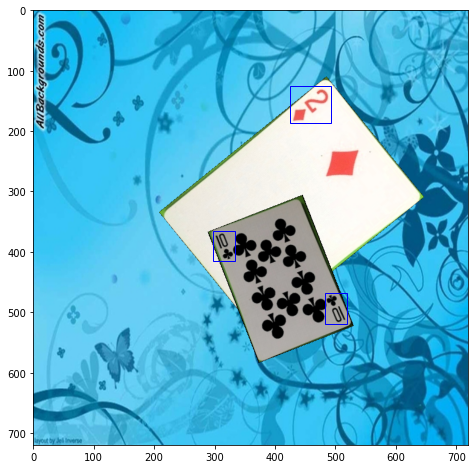

In [ ]:
bg=backgrounds.get_random()
img1,card_val1,hulla1,hullb1=cards.get_random()
img2,card_val2,hulla2,hullb2=cards.get_random()

newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2)
newimg.display()

### 3 card scene

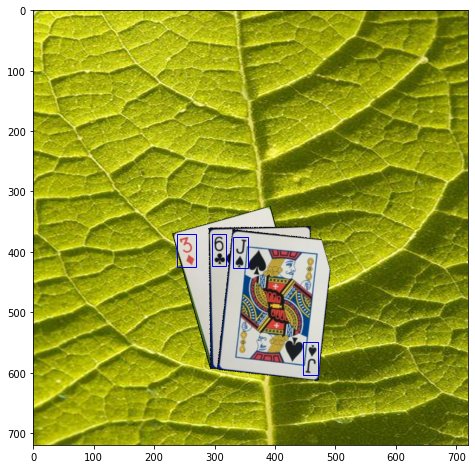

In [ ]:
bg=backgrounds.get_random()
img1,card_val1,hulla1,hullb1=cards.get_random()
img2,card_val2,hulla2,hullb2=cards.get_random()
img3,card_val3,hulla3,hullb3=cards.get_random()

newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2,img3,card_val3,hulla3,hullb3)
newimg.display()

## Generate training data


In [ ]:
gen_training_data(10000, "train")

100%|██████████| 10000/10000 [41:27<00:00,  4.02it/s]


In [ ]:
gen_training_data(3000, "valid")

100%|██████████| 3000/3000 [12:30<00:00,  4.00it/s]


In [ ]:
gen_training_data(1000, "test")

100%|██████████| 1000/1000 [04:11<00:00,  3.98it/s]


In [ ]:
!python convert_voc_yolo.py train cards.names list.txt

['Ah', 'Kh', 'Qh', 'Jh', '10h', '9h', '8h', '7h', '6h', '5h', '4h', '3h', '2h', 'Ad', 'Kd', 'Qd', 'Jd', '10d', '9d', '8d', '7d', '6d', '5d', '4d', '3d', '2d', 'Ac', 'Kc', 'Qc', 'Jc', '10c', '9c', '8c', '7c', '6c', '5c', '4c', '3c', '2c', 'As', 'Ks', 'Qs', 'Js', '10s', '9s', '8s', '7s', '6s', '5s', '4s', '3s', '2s'] 52


In [ ]:
%cp /content/train /content/drive/My\ Drive